In [1]:
%matplotlib notebook

# general tools
import numpy as np
from numpy import random
import scipy as sp

# tree/simulation
from prosstt import simulation as sim
from prosstt import tree
from prosstt import count_model as cm
from prosstt import sim_utils as sut

# dimensionality reduction and visualization
import anndata as ad
from scanpy.api.tl import diffmap
import matplotlib.pyplot as plt

# make sure to use viridis as the default color map
import matplotlib as mpl
mpl.rcParams['image.cmap'] = 'viridis'

/home/npapado/miniconda2/envs/py36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# set random seed
rseed = 42
random.seed(rseed)

make a tree with (almost) default parameters and define sample time and base gene expression values

In [3]:
newick_string = "(B,C)A;"

t = tree.Tree.from_newick(newick_string, genes=300)
sample_time = np.arange(0, t.get_max_time())
gene_scale = np.exp(sp.stats.norm.rvs(loc=0.8, scale=1, size=t.G))

Tree topology | Pseudotime in tree
- | -
<img src="tree.png" alt="topology" style="width: 300px;"/> | <img src="pseudotime.png" alt="pseudotime" style="width: 300px;"/>

simulate average gene expression over the tree

In [4]:
Ms = {}
while not sut.are_lengths_ok(Ms):
    uMs, Ws, Hs = sim.simulate_lineage(t, a=0.05, inter_branch_tol=0.7)
    for i in t.branches:
        Ms[i] = np.exp(uMs[i]) * gene_scale

t.add_genes(Ms)

/home/npapado/miniconda2/envs/py36/lib/python3.6/site-packages/prosstt/simulation.py:180: UserWarning: No argument 'a' specified in kwargs: using gamma and a=0.05
  "No argument 'a' specified in kwargs: using gamma and a=0.05", UserWarning)
/home/npapado/miniconda2/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:3003: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


set variance hyperparameters at three levels and observe how the tree reconstruction changes

values in normal range

In [5]:
alpha1 = np.exp(random.normal(loc=np.log(0.2), scale=np.log(1.5), size=t.G))
beta1 = np.exp(random.normal(loc=np.log(1), scale=np.log(1.5), size=t.G)) + 1

X1, labs1, brns1, scalings1 = sim.sample_whole_tree(t, 1, alpha=alpha1, beta=beta1)

# normalize gene expression by library size
X1 = (X1.transpose() / scalings1).transpose()

 |███████████████████████████████████████████████████████████████████████████████-| 99.2% 

higher average values, same variance

In [6]:
alpha2 = np.exp(random.normal(loc=np.log(1.2), scale=np.log(1.5), size=t.G))
beta2 = np.exp(random.normal(loc=np.log(2), scale=np.log(1.5), size=t.G)) + 1

X2, labs2, brns2, scalings2 = sim.sample_whole_tree(t, 1, alpha=alpha2, beta=beta2)

# normalize gene expression by library size
X2 = (X2.transpose() / scalings2).transpose()

 |███████████████████████████████████████████████████████████████████████████████-| 99.2% 

higher variance for same range

In [7]:
alpha3 = np.exp(random.normal(loc=np.log(0.2), scale=np.log(3.5), size=t.G))
beta3 = np.exp(random.normal(loc=np.log(1), scale=np.log(3.5), size=t.G)) + 1

X3, labs3, brns3, scalings3 = sim.sample_whole_tree(t, 1, alpha=alpha3, beta=beta3)

# normalize gene expression by library size
X3 = (X3.transpose() / scalings3).transpose()

 |███████████████████████████████████████████████████████████████████████████████-| 99.2% 

perform dimensionality reduction and plot to see the differences

<IPython.core.display.Javascript object>


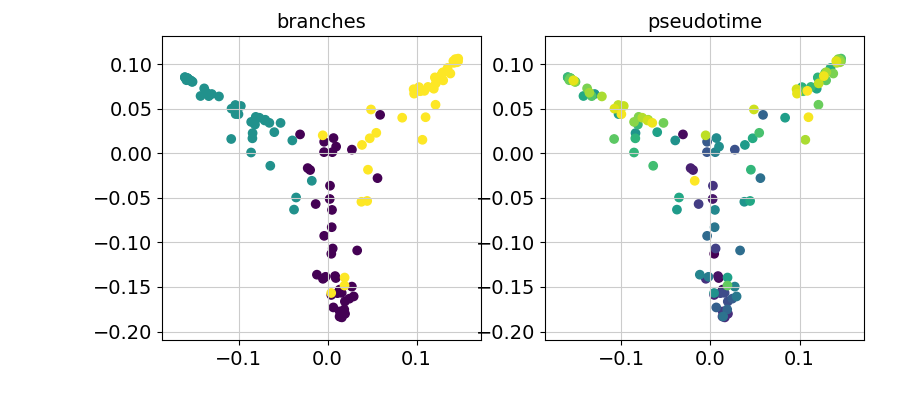

Text(0.5,1,'pseudotime')

In [8]:
data1 = ad.AnnData(X1)
diffmap(adata=data1)
dm1 = data1.obsm["X_diffmap"]

br_names1, indices1 = np.unique(brns1, return_inverse=True)

fig, ax = plt.subplots(ncols=2)
fig.set_size_inches(w=9, h=4)
ax[0].scatter(dm1[:, 0], dm1[:, 1], c=indices1)
ax[0].set_title("branches")
ax[1].scatter(dm1[:, 0], dm1[:, 1], c=labs1)
ax[1].set_title("pseudotime")

The "progenitors" (dark blue) branch out to two different cell fates (left). Pseudotime flows from the progenitors (dark) to the fully differentiated cell fates (yellow)

<IPython.core.display.Javascript object>


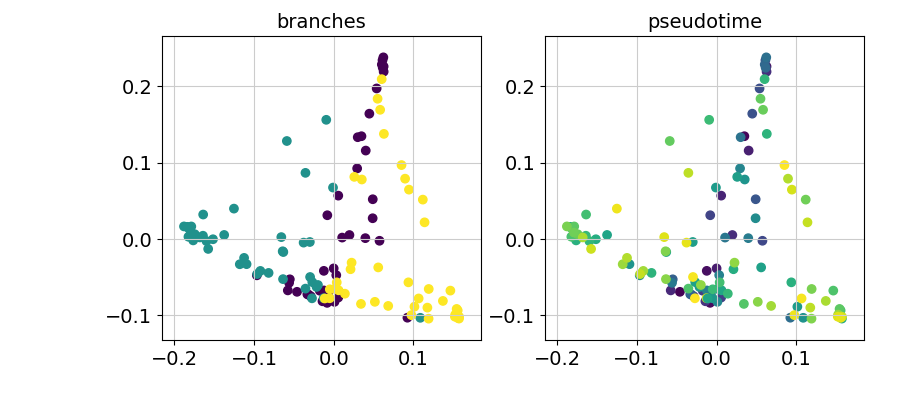

Text(0.5,1,'pseudotime')

In [9]:
data2 = ad.AnnData(X2)
diffmap(adata=data2)
dm2 = data2.obsm["X_diffmap"]

br_names2, indices2 = np.unique(brns2, return_inverse=True)

fig, ax = plt.subplots(ncols=2)
fig.set_size_inches(w=9, h=4)
ax[0].scatter(dm2[:, 0], dm2[:, 1], c=indices2)
ax[0].set_title("branches")
ax[1].scatter(dm2[:, 0], dm2[:, 1], c=labs2)
ax[1].set_title("pseudotime")

While the overall shape of the process is the same, unrealistically high $\alpha$ and $\beta$ values cause the expression profiles of cells at different pseudotimes to mix together, thus obscuring the signal.

<IPython.core.display.Javascript object>


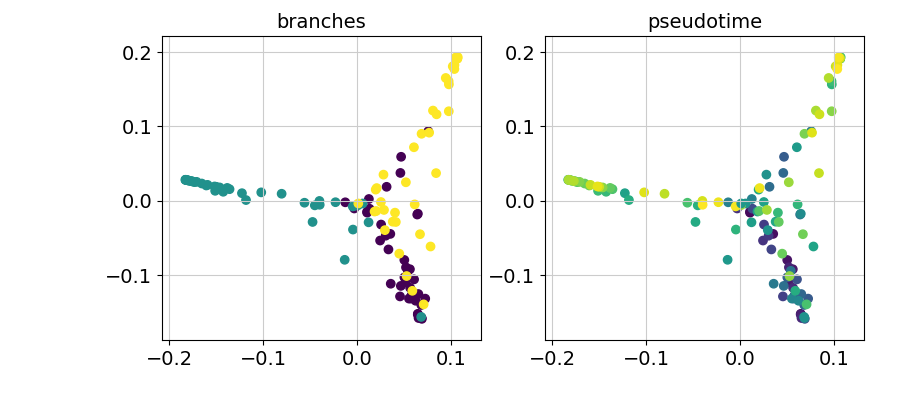

Text(0.5,1,'pseudotime')

In [10]:
data3 = ad.AnnData(X3)
diffmap(adata=data3)
dm3 = data3.obsm["X_diffmap"]

br_names3, indices3 = np.unique(brns3, return_inverse=True)

fig, ax = plt.subplots(ncols=2)
fig.set_size_inches(w=9, h=4)
ax[0].scatter(dm3[:, 0], dm3[:, 1], c=indices3)
ax[0].set_title("branches")
ax[1].scatter(dm3[:, 0], dm3[:, 1], c=labs3)
ax[1].set_title("pseudotime")

Negative binomial parameters chosen with realistic mean but very high variance preserve the shape but have worse separation than in Example 1. There appear "intermediate" cells between the two end cell fates.